In [1]:
# Access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Data Loading

In [2]:
import urllib.request
import librosa

# load wave file
file_url = 'https://github.com/purduelamm/purdue_me597_iiot_online/blob/main/ml_tutorial/Dataset_IndustrialSound/Industrial_data_Stethoscope.wav?raw=true'
file_path = 'Industrial_data_Stethoscope.wav'
urllib.request.urlretrieve(file_url, file_path)

(sound, rate) = librosa.load(file_path, sr=None)
print(rate)

48000


In [3]:
from IPython.display import Audio

# Play sound data
Audio(sound, rate=rate)

Output hidden; open in https://colab.research.google.com to view.

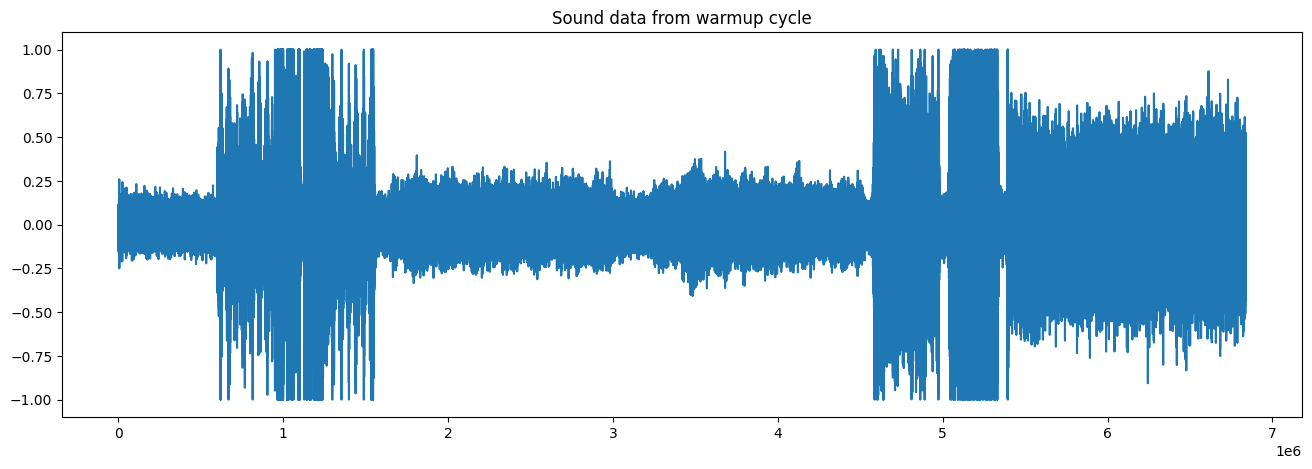

In [4]:
import matplotlib.pyplot as plt

# Plot sound data
plt.figure(figsize=(16,5))
plt.title("Sound data from warmup cycle")
plt.plot(sound)
plt.show()

## Step 2: Data Indexing

In [5]:
import numpy as np

# Index data by timestamps [second]
# class 1 [12.46, 32.51]    Tool Change
# class 2 [32.51, 65.57]    Chip Conveyer
# class 3 [65.57, 95.30]    X
# class 4 [95.30, 104.36]   Y
# class 5 [104.36, 112.12]  Z
# class 6 [112.12, :]       Spindle

timestamp=[12.46, 32.51, 65.57, 95.30, 104.36, 112.12]
index=np.multiply(rate,timestamp).astype(np.int64) # indices must be integers
print(index)

[ 598080 1560480 3147359 4574400 5009280 5381760]


In [6]:
# Index data and split into 6 classes
indexed_data = []
num_class=6
for i in range(num_class):
  if i == num_class-1: #Last segment
    indexed_data.append(sound[index[i]:])
  else:
    indexed_data.append(sound[index[i]:index[i+1]])

for i, c in enumerate(indexed_data):
  print("Class", i+1, c)

Class 1 [ 0.04415894  0.04882812  0.05239868 ... -0.02410889 -0.02539062
 -0.02697754]
Class 2 [-0.02874756 -0.03045654 -0.03216553 ... -0.03585815 -0.03518677
 -0.03457642]
Class 3 [-0.03366089 -0.03225708 -0.03039551 ...  0.07983398  0.07562256
  0.07156372]
Class 4 [0.06835938 0.06542969 0.06298828 ... 0.10250854 0.10235596 0.10235596]
Class 5 [0.10220337 0.10144043 0.1005249  ... 0.07397461 0.07315063 0.07260132]
Class 6 [0.07177734 0.07070923 0.06945801 ... 0.5187988  0.51168823 0.5028076 ]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


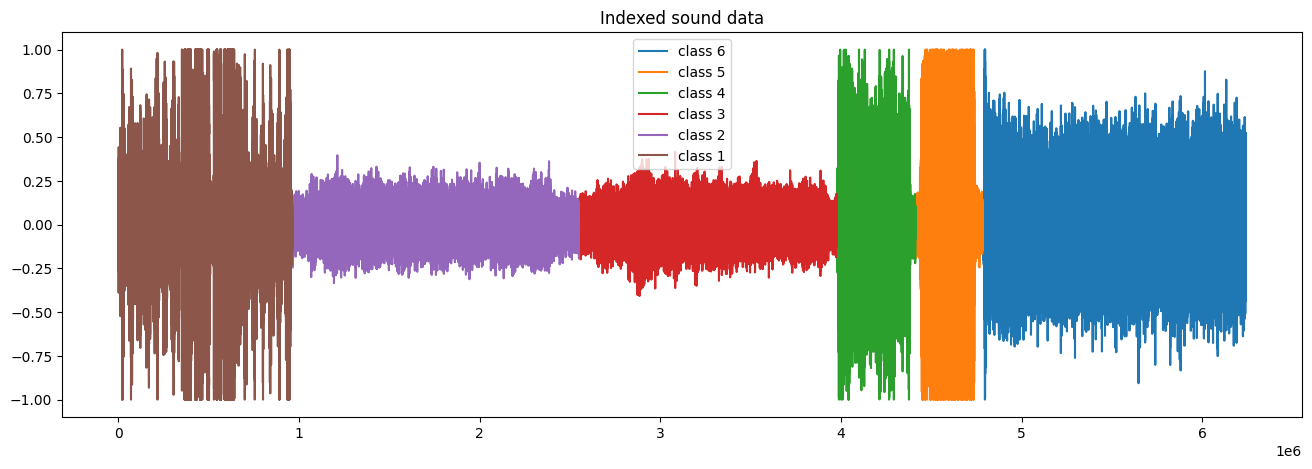

In [7]:
# Pad the segments to plot
current_index = 0
indexed_pad_data=[]
first = True
for i, rg in enumerate(indexed_data):
  if first:
    first = False
    padded_data = rg
    prev_pad = np.zeros(len(rg))
  else:
    padded_data = np.append(prev_pad, rg)
    current_index += len(rg)
    prev_pad = np.append(prev_pad,np.zeros(len(rg)))

  indexed_pad_data.append(padded_data)

# Check padded data
# for i, pad_c in enumerate(indexed_pad_data):
#   print("class with padding", i+1, ":", pad_c)

# Plot and check ranges
plt.figure(figsize=(16,5))
plt.title("Indexed sound data")
for i in reversed(range(num_class)):
  plt.plot(indexed_pad_data[i], label=f"class {i+1}")
plt.legend()
plt.show()

## Step 3: Data Segmentation

In [8]:
# Define variables for segmentation
segment_length=int(1*rate) # 1 segment per 1 second
overlap=int(0.8*rate) # segment with 0.8 second overlap

In [9]:
# Define a function for data segmentation
def segmentation(indexed_data):
  total_length = len(indexed_data)

  # Calculate the number of data points not included in the last segment
  num_total_segments = total_length // (segment_length - overlap) # this variable includes the last segment with fewer values
  last_segment_start = num_total_segments * (segment_length - overlap) # start index of the last segment
  remaining_data = total_length - last_segment_start
  print("Number of data points not included:", remaining_data)

  segments = [] # List to store segments
  start_index = 0 # Start index for segments

  # Loop to create segments
  while start_index + segment_length <= total_length:
      segment = indexed_data[start_index:start_index + segment_length]
      segments.append(segment)
      start_index += segment_length - overlap

  # Check the number of segments
  print("Number of segments:", len(segments))

  # Check results
  # for i, segment in enumerate(segments):
  #     print(f"Segment {i+1}: {segment}")

  # Check all segments have the right length (segment_length)
  # for segment in segments:
  #   print(len(segment))

  return segments

In [10]:
for i in range(num_class):
  exec(f'print("Class {i+1}")')
  exec(f'class_{i+1}=segmentation(indexed_data[{i}])')

Class 1
Number of data points not included: 2400
Number of segments: 96
Class 2
Number of data points not included: 2879
Number of segments: 161
Class 3
Number of data points not included: 6241
Number of segments: 144
Class 4
Number of data points not included: 2880
Number of segments: 41
Class 5
Number of data points not included: 7680
Number of segments: 34
Class 6
Number of data points not included: 6556
Number of segments: 147


In [11]:
import os

# Save the segmented data
save_path="/content/drive/MyDrive/Colab Notebooks/SavedFiles/segments"

for i in range(num_class):
  # option 1: save as numpy array
  exec(f"np.save(os.path.join(save_path, 'class{i+1}'), class_{i+1})")
  # option 2: save array into csv file
  # exec(f"np.savetxt(os.path.join(save_path,'class{i+1}.csv'), class_{i+1}, delimiter = ',')")

In [12]:
import pandas as pd

# Import segmented data
load_path="/content/drive/MyDrive/Colab Notebooks/SavedFiles/segments"

for i in range(num_class):
  # option 1: load numpy array and convert to pandas data frame
  exec(f"class{i+1} = pd.DataFrame(np.load(os.path.join(load_path, 'class{i+1}.npy'))).T")
  # option 2: save array into csv file
  # exec(f"class{i+1} = pd.read_csv(os.path.join(load_path,'class{i+1}.csv'), sep=',', header=None).T")

  exec(f"print('class{i+1}:', class{i+1}.shape)")

class1: (48000, 96)
class2: (48000, 161)
class3: (48000, 144)
class4: (48000, 41)
class5: (48000, 34)
class6: (48000, 147)


## Step 4: Feature extraction

### 4-1. P-value

In [13]:
# Define number of data for each class and number of features
num_data=[]
for i in range(num_class):
  exec(f"num_data.append(class{i+1}.shape[1])")

num_feature = 10 # 10 Feature types: Max, Min, Mean, RMS, Variance, Skewness, Kurtosis, Crest factor, Shape factor, Impulse factor

print("number of data:", num_data, "\nnumber of feature:", num_feature)

number of data: [96, 161, 144, 41, 34, 147] 
number of feature: 10


4-1-1. Time domain feature extraction (ML 3_1)

In [14]:
import scipy.stats as sp

def time_feature_extraction(class_data):
  num_data = class_data.shape[1]

  # Create empty(0) arrays for feature dataset (time domain)
  time_feature_data = np.zeros((num_feature, num_data))

  # Define rms function
  def rms(x):
    return np.sqrt(np.mean(x**2))

  # Time domain feature extraction
  for i in range(num_data):
    time_feature_data[0, i] = np.max(class_data.iloc[:,i])
    time_feature_data[1, i] = np.min(class_data.iloc[:,i])
    time_feature_data[2, i] = np.mean(class_data.iloc[:,i])
    time_feature_data[3, i] = rms(class_data.iloc[:,i])
    time_feature_data[4, i] = np.var(class_data.iloc[:,i])
    time_feature_data[5, i] = sp.skew(class_data.iloc[:,i])
    time_feature_data[6, i] = sp.kurtosis(class_data.iloc[:,i])
    time_feature_data[7, i] = np.max(class_data.iloc[:,i])/rms(class_data.iloc[:,i])
    time_feature_data[8, i] = rms(class_data.iloc[:,i])/np.mean(np.abs(class_data.iloc[:,i]))
    time_feature_data[9, i] = np.max(class_data.iloc[:,i])/np.mean(np.abs(class_data.iloc[:,i]))

  return time_feature_data

In [15]:
for i in range(num_class):
  exec(f"time_feature_class{i+1} = time_feature_extraction(class{i+1})")

In [16]:
# Combine feature arrays
concat_data = [time_feature_class1, time_feature_class2, time_feature_class3, time_feature_class4, time_feature_class5, time_feature_class6]
time_feature = np.concatenate(concat_data , axis=1)
time_feature.shape

(10, 623)

4-1-2. Frequency domain feature extraction (ML 3_1)

In [17]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.2 MB/s eta 0:00:00


In [18]:
import pywt

# Wavelet options
MotherWavelet = pywt.Wavelet('haar') # Mother wavelet
level = 8 # Wavelet decomposition level

In [19]:
def freq_feature_extraction(class_data):
  num_data = class_data.shape[1]

  # Create empty(0) arrays for feature dataset (frequency domain)
  freq_feature_data = np.zeros(shape=(num_feature*level , num_data))

  # Define rms function
  def rms(x):
    return np.sqrt(np.mean(x**2))

  for i in range(num_data):
    # Walvelet decomposition
    coeff = pywt.wavedec(class_data.iloc[:,i], MotherWavelet, level=level, axis=0)

    # Frequency domain feature extraction
    for k in np.arange(level):
      coefficient = coeff[level-k]

      freq_feature_data[k*num_feature+0, i] = np.max(coefficient)
      freq_feature_data[k*num_feature+1, i] = np.min(coefficient)
      freq_feature_data[k*num_feature+2, i] = np.mean(coefficient)
      freq_feature_data[k*num_feature+3, i] = rms(coefficient)
      freq_feature_data[k*num_feature+4, i] = np.var(coefficient)
      freq_feature_data[k*num_feature+5, i] = sp.skew(coefficient)
      freq_feature_data[k*num_feature+6, i] = sp.kurtosis(coefficient)
      freq_feature_data[k*num_feature+7, i] = np.max(coefficient)/rms(coefficient)
      freq_feature_data[k*num_feature+8, i] = rms(coefficient)/np.mean(np.abs(coefficient))
      freq_feature_data[k*num_feature+9, i] = np.max(coefficient)/np.mean(np.abs(coefficient))

  return freq_feature_data

In [20]:
for i in range(num_class):
  exec(f"freq_feature_class{i+1} = freq_feature_extraction(class{i+1})")

In [21]:
# Combine feature arrays
concat_data = [freq_feature_class1, freq_feature_class2, freq_feature_class3, freq_feature_class4, freq_feature_class5, freq_feature_class6]
freq_feature = np.concatenate(concat_data , axis=1)
freq_feature.shape

(80, 623)

In [22]:
# Final feature dataset
# 10 Time domain features + 80 Frequency domain features = 90 features
features = np.concatenate([time_feature,freq_feature] , axis=0)

print("Shape of the total features:", features.shape)

# Convert array into data frame format
feature_df = pd.DataFrame(features)

Shape of the total features: (90, 623)


In [23]:
feature_save_path = "/content/drive/MyDrive/Colab Notebooks/SavedFiles/feature_dataset.csv"
feature_df.to_csv(feature_save_path, sep=',', header=None , index=None)

4-1-3. P-value calculation (ANOVA) (ML 3_2)
- Unlike using the t-test to select advantageous features for binary classification, we typically use the ANOVA (Analysis of Variance) test for feature selection in **multi-class classification** problems.
- For the Python code, it is very similar to what we did with the 't-test', and ultimately, the result we want to know is the same: the P-value.
- To perform the ANOVA test, you just need to replace the t-test function (sp.ttest_ind) with the ANOVA execution function (sp.f_oneway). (Of course, the input parameters should include the feature datasets for all classes.)
- If you want to understand more about the ANOVA test, refer to the video below.

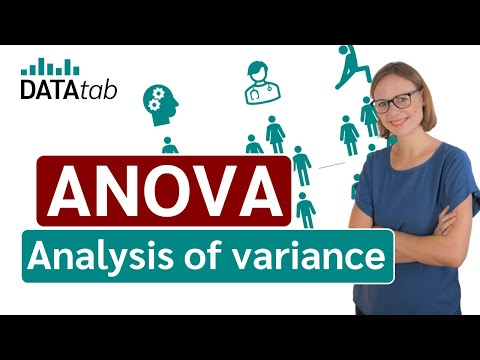

In [24]:
from IPython.display import YouTubeVideo
YouTubeVideo('0NwA9xxxtHw')

In [25]:
feature_load_path = "/content/drive/MyDrive/Colab Notebooks/SavedFiles/feature_dataset.csv"

feature_data = pd.read_csv(feature_load_path, header=None)

In [26]:
num_data=[]
for i in range(num_class):
  exec(f"num_data.append(class{i+1}.shape[1])")

# Calculate the index
d_index = [sum(num_data[:i+1]) for i in range(len(num_data))]

# Index feature data
first = True
for i in range(num_class):
  if first:
    exec(f"c{i+1}_feature = feature_data.iloc[:,:d_index[{i}]]")
    first = False
  else:
    exec(f"c{i+1}_feature = feature_data.iloc[:,d_index[{i-1}]:d_index[{i}]]")
  exec(f"print(c{i+1}_feature.shape)")

(90, 96)
(90, 161)
(90, 144)
(90, 41)
(90, 34)
(90, 147)


In [27]:
num_feature = feature_data.shape[0] # Number of feature: 90

# Create empty(0) arrays for p-value dataset
p_value = np.zeros((num_feature, 2))

# P-value by ANOVA
for i in np.arange(num_feature):
  anova = np.array(sp.f_oneway(c1_feature.iloc[i,:], c2_feature.iloc[i,:], c3_feature.iloc[i,:], c4_feature.iloc[i,:], c5_feature.iloc[i,:], c6_feature.iloc[i,:]))
  p_value[i,0] = int(i) # Index of feature (0~89)
  p_value[i,1] = anova[1] # p-value

p_value = pd.DataFrame(p_value, columns=['No.', 'P-value'])
p_value

,No.,P-value
0,0.0,0.000000e+00
1,1.0,0.000000e+00
2,2.0,2.711030e-12
3,3.0,5.884906e-177
4,4.0,3.140021e-98
...,...,...
85,85.0,6.797574e-02
86,86.0,2.214137e-90
87,87.0,8.084487e-34
88,88.0,5.093821e-102


In [28]:
# Sort by P-value in ascending order
p_value_rank = p_value.sort_values(['P-value'], ascending=True)
p_value_rank

,No.,P-value
0,0.0,0.000000e+00
1,1.0,0.000000e+00
50,50.0,1.223884e-275
51,51.0,8.483250e-264
61,61.0,4.118030e-262
...,...,...
85,85.0,6.797574e-02
12,12.0,2.553379e-01
52,52.0,4.414499e-01
22,22.0,9.363459e-01


In [29]:
# Save t-Test result (p-value)
p_path = '/content/drive/MyDrive/Colab Notebooks/SavedFiles/P_value.csv'
p_rank_path = '/content/drive/MyDrive/Colab Notebooks/SavedFiles/P_value_Rank.csv'

p_value.to_csv(p_path, sep=',', header=None, index=None)
p_value_rank.to_csv(p_rank_path, sep=',', header=None, index=None)

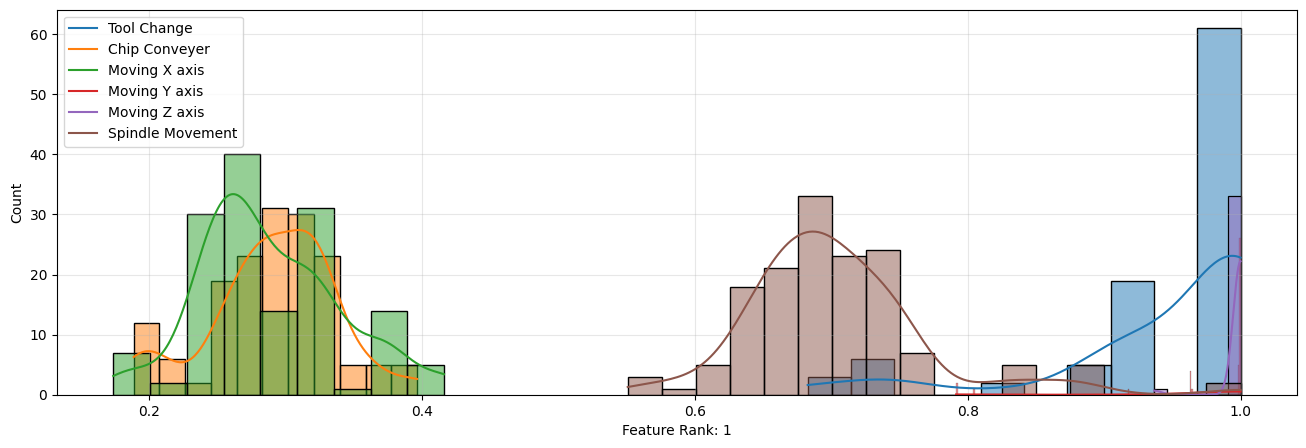

In [30]:
import seaborn as sb

# Confirm PDF(Probabilistic Density Function) graphs
# P-value rank (0 ~ 89)
FeatureRank = 0

# PDF Chart
class_label=['Tool Change', 'Chip Conveyer', 'Moving X axis', 'Moving Y axis', 'Moving Z axis', 'Spindle Movement']
plt.figure(figsize=(16,5))

for i in range(num_class):
  exec(f"sb.histplot(c{i+1}_feature.iloc[int(p_value_rank.iloc[FeatureRank,0]),:], kde=True)")

plt.legend(class_label, loc='best', fontsize=10)
plt.xlabel(f'Feature Rank: {FeatureRank+1}')
plt.grid(alpha=0.3)
plt.show()

In [31]:
# Select top features having low P-values
rank = 30  # Select number of rank

def feature_selection(class_feature):
  num_data=class_feature.shape[1]
  selected_feature = np.zeros((rank,num_data))
  for i in range(rank):
    index = int(p_value_rank.iloc[i,0])
    selected_feature[i,:] = class_feature.iloc[index,:].values
  return selected_feature

for i in range(num_class):
  exec(f"c{i+1}=feature_selection(c{i+1}_feature)")

FeatureSelected = pd.DataFrame(np.concatenate([c1, c2, c3, c4, c5, c6] , axis=1))

print("Selected Feature Data Size :", FeatureSelected.shape)

Selected Feature Data Size : (30, 623)


In [32]:
# Save selected feature data as csv file

sel_feature_path = '/content/drive/MyDrive/Colab Notebooks/SavedFiles/FeatureSelected.csv'
FeatureSelected.to_csv(sel_feature_path, sep=',', header=None, index=None)

### 4-2. STFT (Short-Time Fourier Transform) (ML 6_1)

In [33]:
# Import segmented data
load_path="/content/drive/MyDrive/Colab Notebooks/SavedFiles/segments"

for i in range(num_class):
  # option 1: load numpy array and convert to pandas data frame
  exec(f"class{i+1} = pd.DataFrame(np.load(os.path.join(load_path, 'class{i+1}.npy')))")
  # option 2: save array into csv file
  # exec(f"class{i+1} = pd.read_csv(os.path.join(load_path,'class{i+1}.csv'), sep=',', header=None)")
  exec(f"print('class{i+1}:', class{i+1}.shape)")

class1: (96, 48000)
class2: (161, 48000)
class3: (144, 48000)
class4: (41, 48000)
class5: (34, 48000)
class6: (147, 48000)


In [34]:
data_list = [class1, class2, class3, class4, class5, class6]
SoundData = np.concatenate(data_list , axis=0)
print(SoundData.shape)

(623, 48000)


In [35]:
from scipy import signal

Fs = rate  # sampling frequency
nperseg = 78 # number of samples per segment
noverlap = 10 # number of samples for overlap

f,t,soundSTFT = signal.spectrogram(SoundData, Fs, nperseg=nperseg, noverlap=noverlap)
print(soundSTFT.shape)

(623, 40, 705)


In [36]:
num_data=[]
for i in range(num_class):
  exec(f"num_data.append(class{i+1}.shape[0])")

# Calculate the index
d_index = [sum(num_data[:i+1]) for i in range(len(num_data))]

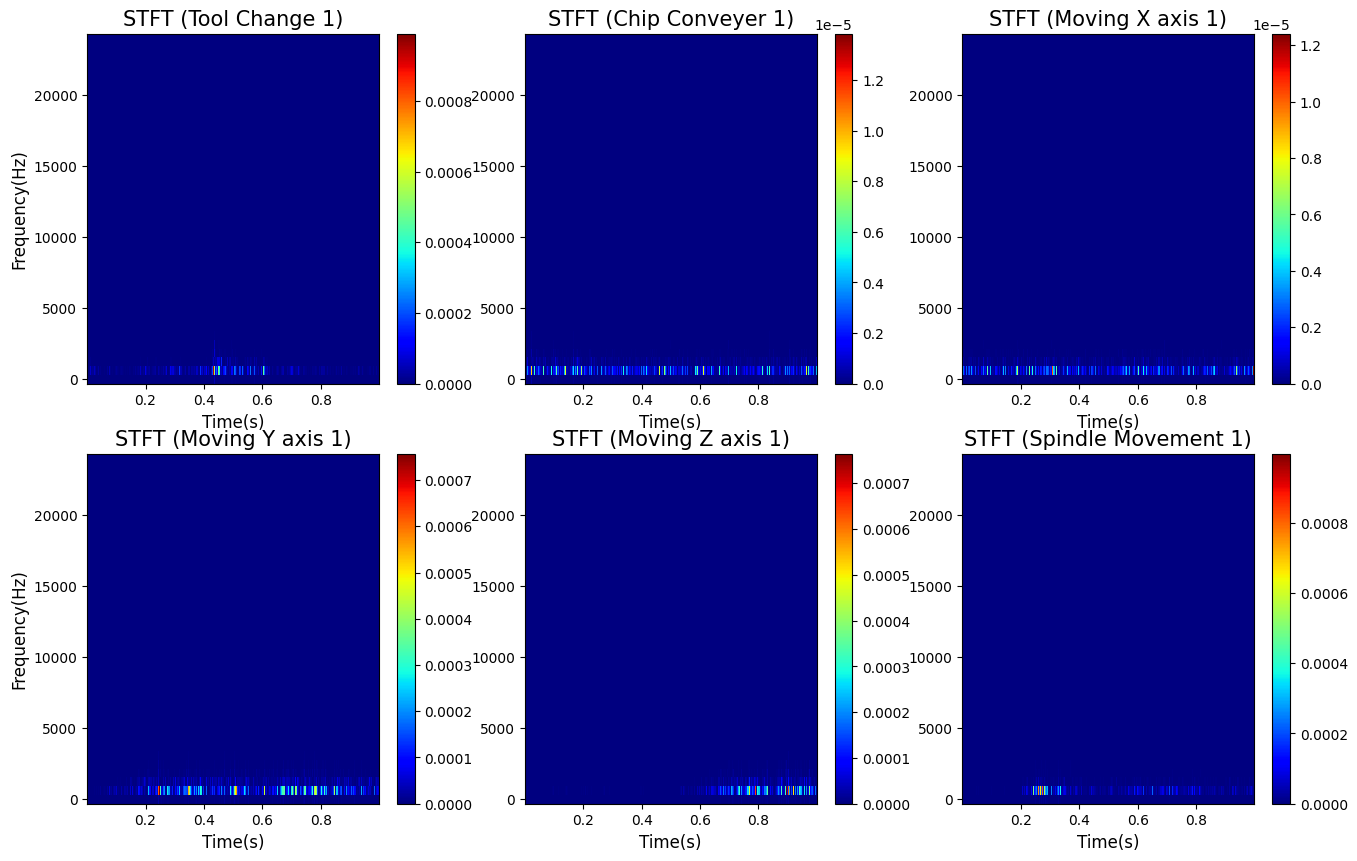

In [37]:
class_label=['Tool Change', 'Chip Conveyer', 'Moving X axis', 'Moving Y axis', 'Moving Z axis', 'Spindle Movement']

idx = 1 # Select index

first=True
plt.figure(figsize=(16,10))
for i in range(len(d_index)):
    plt.subplot(2, 3, i+1)
    if first:
      plt.pcolormesh(t, f, soundSTFT[idx-1], cmap='jet')
      first=False
    else:
      plt.pcolormesh(t, f, soundSTFT[idx + d_index[i-1]-1], cmap='jet')
    plt.title(f"STFT ({class_label[i]} {idx})", fontsize=15)
    plt.xlabel('Time(s)', fontsize=12)
    if i in [0, 3]:
        plt.ylabel('Frequency(Hz)', fontsize=12)
    plt.colorbar()

plt.show()

In [38]:
# Save STFT as a NumPy file
# Save the segmented data
stft_save_path="/content/drive/MyDrive/Colab Notebooks/SavedFiles"

np.save(os.path.join(stft_save_path, "SoundSTFT.npy"), soundSTFT)

In [39]:
import scipy.stats       as sp
import tensorflow        as tf
from tensorflow                 import keras
from keras.models    import Model
from sklearn.model_selection    import train_test_split

In [40]:
# Define each condition's name and number of samples
cond = ['Tool Change', 'Chip Conveyer', 'Moving X axis', 'Moving Y axis', 'Moving Z axis', 'Spindle Movement']

NoOfData = pd.DataFrame([96, 161, 144, 41, 34, 147])
NoOfData

,0
0,96
1,161
2,144
3,41
4,34
5,147


In [41]:
# Load STFT dataset that you saved in ML8
DataSet = np.load('/content/drive/MyDrive/Colab Notebooks/SavedFiles/SoundSTFT.npy')[:,:,:-1]
DataSet.shape

(623, 40, 704)

In [42]:
# Check the width and height of each STFT spectrogram
width, height = DataSet.shape[1], DataSet.shape[2]
width, height

(40, 704)

In [43]:
# Scale the Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from joblib import dump, load

DataSet_2d = DataSet.reshape(DataSet.shape[0],-1)
print(DataSet_2d.shape)

scaler_std = StandardScaler()
scaler_mMx = MinMaxScaler()
DataSet_2d_scaled_1 = scaler_std.fit_transform(DataSet_2d)
DataSet_2d_scaled_2 = scaler_mMx.fit_transform(DataSet_2d_scaled_1)

DataSet_scaled = DataSet_2d_scaled_2.reshape(DataSet.shape[0], DataSet.shape[1], DataSet.shape[2])
print(DataSet_scaled.shape)

(623, 28160)
(623, 40, 704)


In [44]:
# Assuming `stft_image` is (40, 704), -> mobilenet_v2 requires 224x224x3 image size
def preprocess_stft(stft_image, target_shape):
    image = tf.image.resize(stft_image, target_shape)
    image = tf.image.grayscale_to_rgb(tf.expand_dims(image, -1))  # shape: (224, 224, 3)
    return image

In [45]:
shape = [224, 224]
DataSet_rsp = preprocess_stft(DataSet_scaled.reshape(width, height, -1), shape)
DataSet_rsp = tf.reshape(DataSet_rsp, (-1, shape[0], shape[1], 3)).numpy()

In [46]:
print(DataSet_rsp.shape[1:])

(224, 224, 3)


In [47]:
# Prepare train/test dataset for Conv_AE modeling
Train_Test_Ratio = 0.2

DataSet_1 = DataSet_rsp[sum(NoOfData.iloc[:0,0]):sum(NoOfData.iloc[:0,0])+NoOfData.iloc[0,0]]
DataSet_2 = DataSet_rsp[sum(NoOfData.iloc[:1,0]):sum(NoOfData.iloc[:1,0])+NoOfData.iloc[1,0]]
DataSet_3 = DataSet_rsp[sum(NoOfData.iloc[:2,0]):sum(NoOfData.iloc[:2,0])+NoOfData.iloc[2,0]]
DataSet_4 = DataSet_rsp[sum(NoOfData.iloc[:3,0]):sum(NoOfData.iloc[:3,0])+NoOfData.iloc[3,0]]
DataSet_5 = DataSet_rsp[sum(NoOfData.iloc[:4,0]):sum(NoOfData.iloc[:4,0])+NoOfData.iloc[4,0]]
DataSet_6 = DataSet_rsp[sum(NoOfData.iloc[:5,0]):sum(NoOfData.iloc[:5,0])+NoOfData.iloc[5,0]]

TrainD1, TestD1, = train_test_split(DataSet_1, test_size=Train_Test_Ratio, random_state = 777)
TrainD2, TestD2, = train_test_split(DataSet_2, test_size=Train_Test_Ratio, random_state = 777)
TrainD3, TestD3, = train_test_split(DataSet_3, test_size=Train_Test_Ratio, random_state = 777)
TrainD4, TestD4, = train_test_split(DataSet_4, test_size=Train_Test_Ratio, random_state = 777)
TrainD5, TestD5, = train_test_split(DataSet_5, test_size=Train_Test_Ratio, random_state = 777)
TrainD6, TestD6, = train_test_split(DataSet_6, test_size=Train_Test_Ratio, random_state = 777)

TrainData  = np.concatenate([TrainD1, TrainD2, TrainD3, TrainD4, TrainD5, TrainD6], axis=0)
TestData   = np.concatenate([TestD1 , TestD2 , TestD3 , TestD4, TestD5, TestD6 ], axis=0)

# Create a label for each data (e.g., 0, 1, 2, 3, 4, 5)
TrainLabel = np.concatenate([np.zeros(TrainD1.shape[0]), np.ones(TrainD2.shape[0]), 2 * np.ones(TrainD3.shape[0]), 3 * np.ones(TrainD4.shape[0]), 4 * np.ones(TrainD5.shape[0]), 5 * np.ones(TrainD6.shape[0])])
TestLabel = np.concatenate([np.zeros(TestD1.shape[0]), np.ones(TestD2.shape[0]), 2 * np.ones(TestD3.shape[0]), 3 * np.ones(TestD4.shape[0]), 4 * np.ones(TestD5.shape[0]), 5 * np.ones(TestD6.shape[0])])
TrainLabel = TrainLabel.astype(int)
TestLabel = TestLabel.astype(int)

TrainData.shape , TestData.shape

((495, 224, 224, 3), (128, 224, 224, 3))

In [48]:
IMG_SHAPE = DataSet_rsp.shape[1:]

In [49]:
# To rescale them, we use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [50]:
# --- 4. Create TensorFlow Datasets ---
batch_size = 16

train_ds = tf.data.Dataset.from_tensor_slices((TrainData, TrainLabel))
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((TestData, TestLabel))
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [51]:
from tensorflow.keras import layers, models

# This will "freeze" weights and biases in our base model.
# In other words, there will be no backpropagation of the loss graidents to update weights and biases in the NN.
base_model.trainable = True

# Now, let's design our own classification head for our own application
# When generating your own NN model, make sure that intermediate dimenions between layers are correct!
# Let's first check output dimension of the base_model
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Since we are going to design a simple binary classifiation model, we will use average pooling layer to obtain a global feature of an inpute image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Then, make sure that we get the expected shape after going to our classification head.
prediction_layer = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_class, activation='softmax')  # 6 sound classes
])
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# Finally, let's build our model.
# We will also check whether our model works as expected. We will use a dummy image to test the model.
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

(16, 7, 7, 1280)
(16, 1280)
(16, 6)
Number of layers in the base model:  154


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 6)              │       164,742 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 1,204,742 (4.60 MB)

 Non-trainable params: 1,217,984 (4.65 MB)

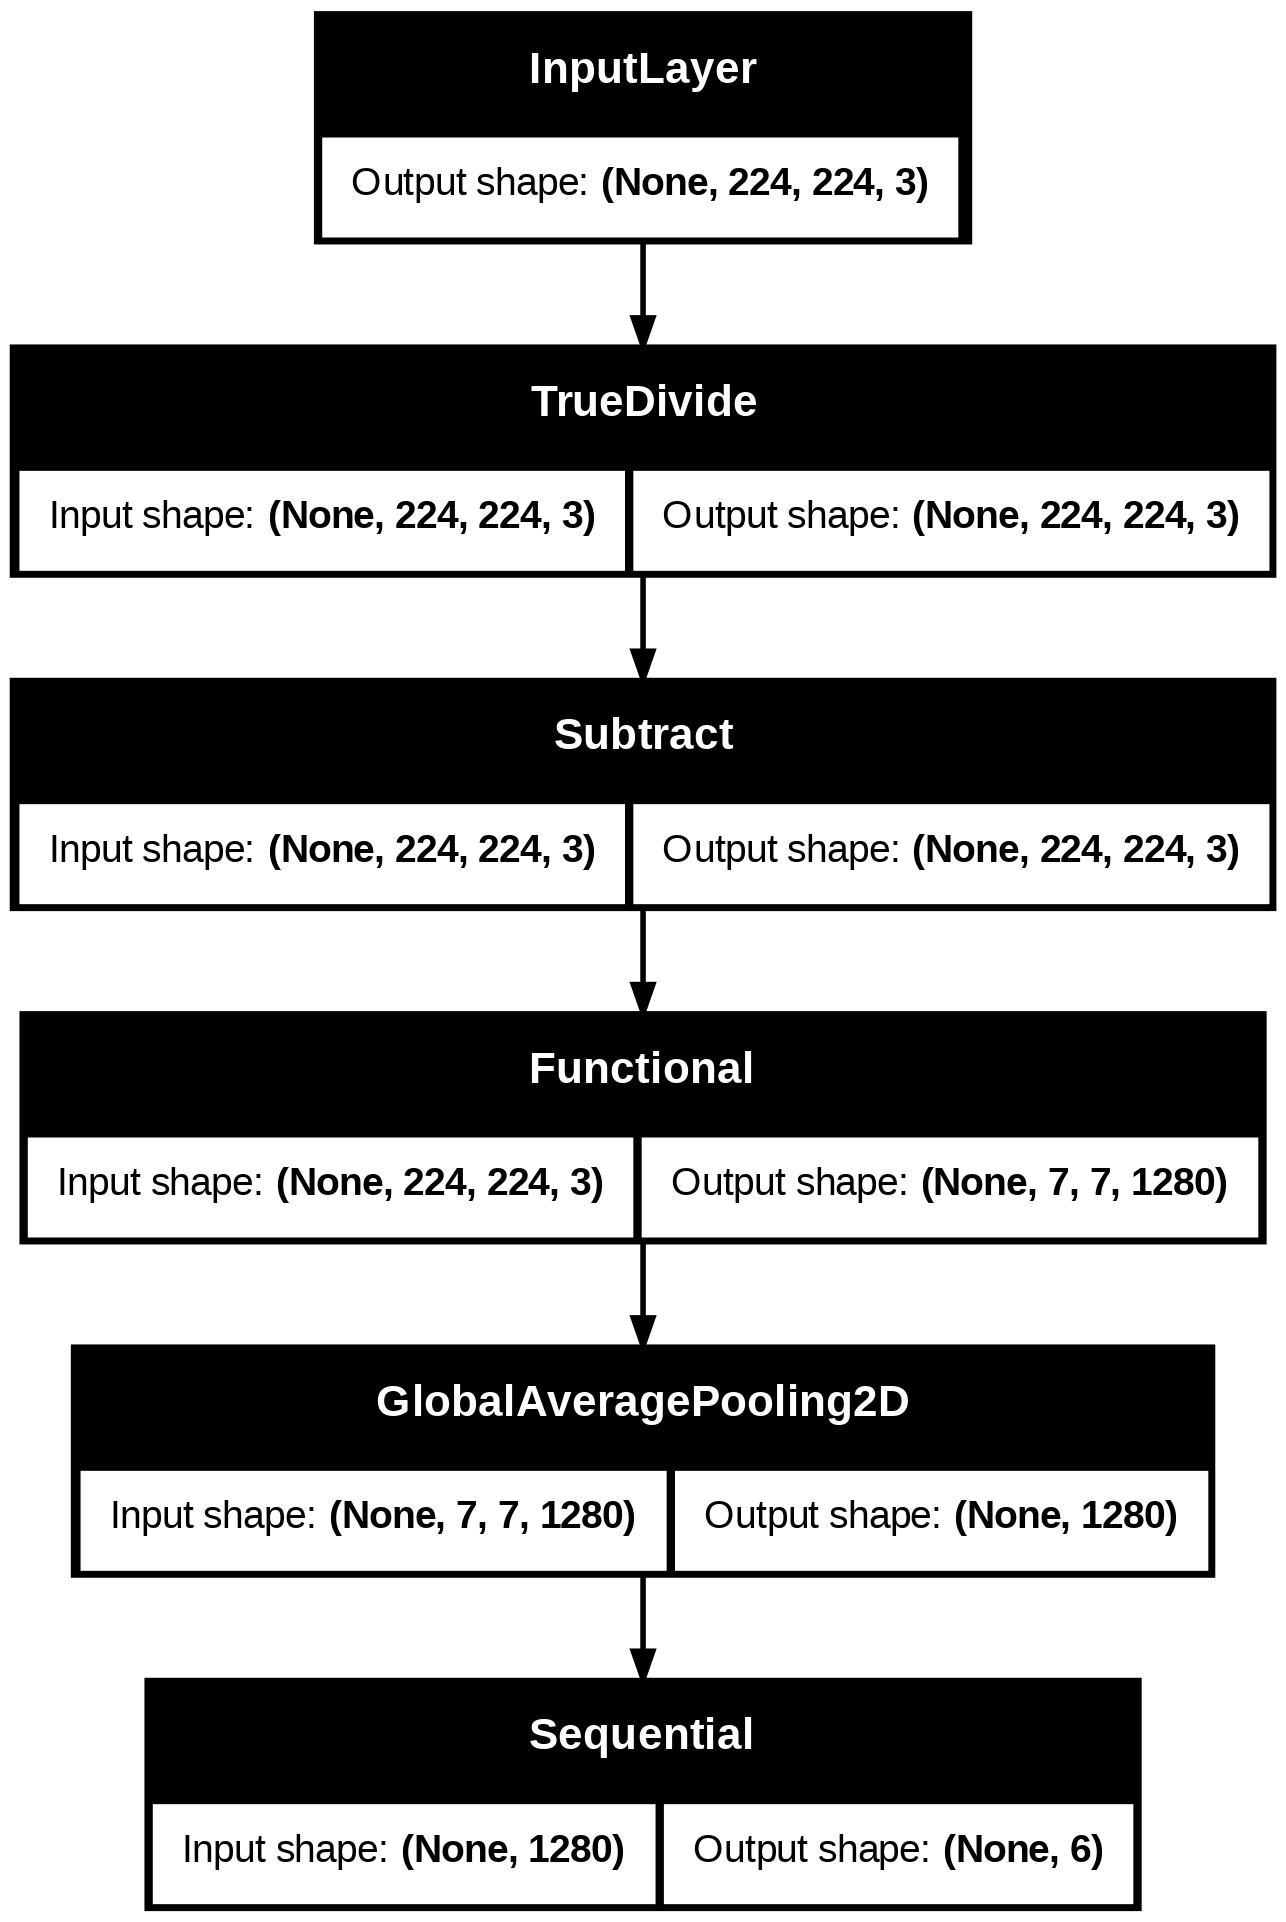

In [52]:
# Check how many parameters are trainable
model.summary()
len(model.trainable_variables)
tf.keras.utils.plot_model(model, show_shapes=True)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.0350 - loss: 2.6453
initial loss: 2.40
initial accuracy: 0.07
Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.2347 - loss: 1.8002 - val_accuracy: 0.2578 - val_loss: 2.0610
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3063 - loss: 1.6343 - val_accuracy: 0.2578 - val_loss: 2.2423
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3056 - loss: 1.5062 - val_accuracy: 0.2344 - val_loss: 3.0304
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3565 - loss: 1.4465 - val_accuracy: 0.2344 - val_loss: 4.1550
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3156 - loss: 1.4026 - val_accuracy: 0.2578 - val_loss: 5.2012
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4073 - loss: 1.3788 - val_accuracy: 0.2578 - val_loss: 5.4692
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4094 - loss: 1.3327 - val_accuracy: 0.2266 - val_loss: 5.

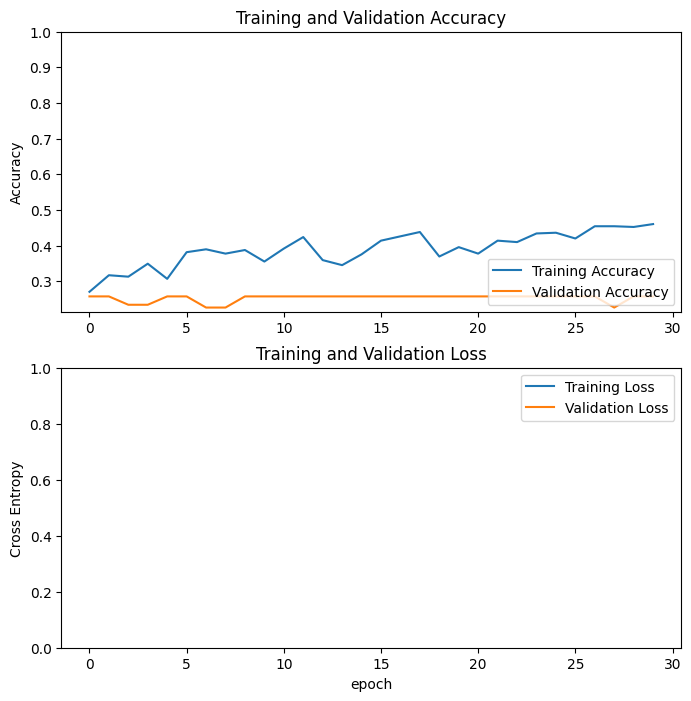

In [53]:
base_learning_rate = 0.0005 # Another important hyperparameter to train our model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Let's see how this process will improve our NN after 10 epochs of training.
epochs = 30
loss0, accuracy0 = model.evaluate(val_ds)

print(f"initial loss: {loss0:.2f}")
print(f"initial accuracy: {accuracy0:.2f}")

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Visualization of loss and accuracy during the training process
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [54]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load selected feature data and P-values at Step 4-1 in ML8_1
feature_path = "/content/drive/MyDrive/Colab Notebooks/SavedFiles/FeatureSelected.csv"
p_rank_path = '/content/drive/MyDrive/Colab Notebooks/SavedFiles/P_value_Rank.csv'

FeatureSelected = pd.read_csv(feature_path, header=None)
P_value_Rank = pd.read_csv(p_rank_path , header=None)

# Standardize the selected features
FeatureSelected_std = StandardScaler().fit_transform(pd.DataFrame(FeatureSelected).T)
FeatureSelected_std.shape

(623, 30)

In [55]:
# Split feature data into 6 classes back
num_class=6
num_data=[96, 161, 144, 41, 34, 147] # 1 segment per 1 second with 0.8 second overlap

# Calculate the index
d_index = [sum(num_data[:i+1]) for i in range(len(num_data))]

# Index feature data
first = True
for i in range(num_class):
  if first:
    exec(f"class{i+1}_set = FeatureSelected_std[:d_index[{i}]]")
    first = False
  else:
    exec(f"class{i+1}_set = FeatureSelected_std[d_index[{i-1}]:d_index[{i}]]")
  exec(f"print('class', {i+1}, class{i+1}_set.shape)")

class 1 (96, 30)
class 2 (161, 30)
class 3 (144, 30)
class 4 (41, 30)
class 5 (34, 30)
class 6 (147, 30)


In [56]:
from sklearn.model_selection import train_test_split

# Define the test data ratio
test_ratio = 0.2

# Split the datasets into training and test sets
for i in range(num_class):
  exec(f"train_class{i+1}, test_class{i+1} = train_test_split(class{i+1}_set, test_size=test_ratio, random_state=777)")

  exec(f"print('- class', {i+1},'train data', train_class{i+1}.shape, 'test data',test_class{i+1}.shape)")
print("\n")

# Make label data (One-hot Encoding)
for i in range(num_class):
  exec(f"TrainLabel_class{i+1}=np.zeros((train_class{i+1}.shape[0],num_class))")
  exec(f"TestLabel_class{i+1}=np.zeros((test_class{i+1}.shape[0],num_class))")

  exec(f"TrainLabel_class{i+1}[:,{i}]=1")
  exec(f"TestLabel_class{i+1}[:,{i}]=1")

  exec(f"print('- class', {i+1},'train label',TrainLabel_class{i+1}.shape, 'test label', TestLabel_class{i+1}.shape)")
print("\n")

# Combine the classified data/labels
TrainData = np.concatenate([train_class1, train_class2, train_class3, train_class4, train_class5, train_class6], axis=0)
TestData = np.concatenate([test_class1, test_class2, test_class3, test_class4, test_class5, test_class6], axis=0)
TrainLabel = np.concatenate([TrainLabel_class1, TrainLabel_class2, TrainLabel_class3, TrainLabel_class4, TrainLabel_class5, TrainLabel_class6], axis=0)
TestLabel = np.concatenate([TestLabel_class1, TestLabel_class2, TestLabel_class3, TestLabel_class4, TestLabel_class5, TestLabel_class6], axis=0)

print("- total train data", TrainData.shape,  ", test data", TestData.shape)
print("- total train label", TrainLabel.shape, ", test label",TestLabel.shape)

- class 1 train data (76, 30) test data (20, 30)
- class 2 train data (128, 30) test data (33, 30)
- class 3 train data (115, 30) test data (29, 30)
- class 4 train data (32, 30) test data (9, 30)
- class 5 train data (27, 30) test data (7, 30)
- class 6 train data (117, 30) test data (30, 30)


- class 1 train label (76, 6) test label (20, 6)
- class 2 train label (128, 6) test label (33, 6)
- class 3 train label (115, 6) test label (29, 6)
- class 4 train label (32, 6) test label (9, 6)
- class 5 train label (27, 6) test label (7, 6)
- class 6 train label (117, 6) test label (30, 6)


- total train data (495, 30) , test data (128, 30)
- total train label (495, 6) , test label (128, 6)


In [57]:
# Set hyperparameters for grid search
activation_function = ['tanh', 'relu'] # activation function
hidden_layer = [2, 3] # number of hiddent layers
learning_rate = [0.001, 0.01] # learning rate

# Set hyperparameters for each training
num_neuron = 16
epoch = 300

# Calculate the number of cases
num_case = len(activation_function) * len(hidden_layer) * len(learning_rate)
print("We're gonna run", num_case, "models")

We're gonna run 8 models


In [58]:
# Define a function to create ANN models by inputting the hyperparameters for grid search

def ANN_model(input_data, num_neuron, temp_actfn, temp_layer, temp_lr):
    keras.backend.clear_session()  # Clearing the Keras backend session (initiating variables)

    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_data.shape[1],)))  # Input Layer

    for i in range(temp_layer):
        model.add(keras.layers.Dense(units=num_neuron, activation=temp_actfn, name=f'Hidden{i+1}'))  # Hidden Layer

    model.add(keras.layers.Dense(units=6, activation='softmax', name='Output'))  # Output Layer

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=temp_lr),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [59]:
# Create an empty dataframe to store the accuracy results
Accuracy_df = pd.DataFrame(np.zeros(shape=(num_case, 4)), columns=['Activation Function', 'Num of hidden layer', 'Learning rate', 'Accuracy'])

In [60]:
# Initialize a count value to store the performance of each model
cnt = 0

# Iterate through all possible combinations of activation functions, hidden layers, and learning rates
for act_func in activation_function: # Select each activation function in the list
    for layer in hidden_layer: # Select each hidden layer configuration in the list
        for lr in learning_rate: # Select each learning rate value in the list

            # Create, train, and validate a temporary ANN model with the current combination of hyperparameters
            temp_ann_model = ANN_model(TrainData, num_neuron, act_func, layer, lr)
            temp_ann_model.fit(TrainData, TrainLabel, epochs=epoch, verbose=0)
            Loss, Accuracy = temp_ann_model.evaluate(TestData,  TestLabel, verbose=0)

            # Save the temporary model to a file with a corresponding name
            temp_ann_model_name = f'ANN_{act_func}_L{layer}_LR{lr:.4f}.h5'
            temp_ann_model.save('YOUR_PATH/GridSearch_ANN/' + temp_ann_model_name)

            # Store the performance (accuracy) of the temporary model in the dataframe
            Accuracy_df.iloc[cnt, :] = [act_func, layer, lr, Accuracy]
            cnt += 1

# Display the resulting dataframe with model performances
Accuracy_df

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
<ipython-input-60-6dcc2bd7e8f2>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'tanh' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Accuracy_df.iloc[cnt, :] = [act_func, layer, lr, Accuracy]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(

,Activation Function,Num of hidden layer,Learning rate,Accuracy
0,tanh,2.0,0.001,0.960938
1,tanh,2.0,0.010,0.976562
2,tanh,3.0,0.001,0.984375
3,tanh,3.0,0.010,0.945312
4,relu,2.0,0.001,0.968750
5,relu,2.0,0.010,0.984375
6,relu,3.0,0.001,0.984375
7,relu,3.0,0.010,0.960938


In [61]:
# Calculate mean and standard deviation accuracy for each activation function
mean_accuracy_actfn = Accuracy_df.groupby(['Activation Function'])['Accuracy'].agg(['mean', 'std']).reset_index()

# Calculate mean and standard deviation of accuracy for each hidden layer
mean_accuracy_layer = Accuracy_df.groupby(['Num of hidden layer'])['Accuracy'].agg(['mean', 'std']).reset_index()

# Calculate mean and standard deviation of accuracy for each learning rate
mean_accuracy_lr = Accuracy_df.groupby(['Learning rate'])['Accuracy'].agg(['mean', 'std']).reset_index()

print("Mean accuarcy\n", mean_accuracy_actfn,"\n\n", mean_accuracy_layer, "\n\n",mean_accuracy_lr)

Mean accuarcy
   Activation Function      mean       std
0                relu  0.974609  0.011719
1                tanh  0.966797  0.017323 

    Num of hidden layer      mean       std
0                  2.0  0.972656  0.010086
1                  3.0  0.968750  0.019137 

    Learning rate      mean       std
0          0.001  0.974609  0.011719
1          0.010  0.966797  0.017323


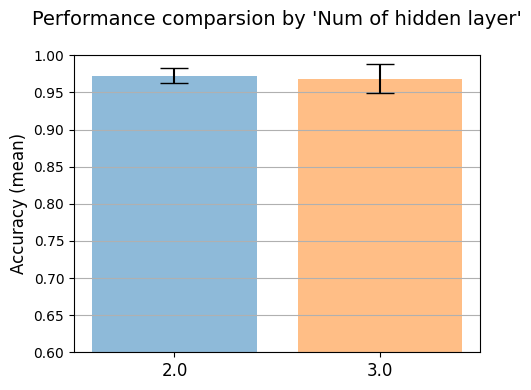

In [62]:
# Set an index to select a hyperparmeter
# 0: activation function // 1: number of hidden layers // 2: learning rate
idx = 1

# Automatically define variables based on the selected index
hyper_param = ['actfn', 'layer', 'lr']
hyper_param_name = ['Activation Function', 'Num of hidden layer', 'Learning Rate']
selected = hyper_param[idx]
selected_name = hyper_param_name[idx]
exec('Result = mean_accuracy_' + hyper_param[idx])

xLabel = Result.iloc[:, 0]
x_pos = np.arange(Result.shape[0])
y_val = Result['mean']
y_err = Result['std']

# Draw a bar chart to compare the model performance (diagnostic accuracy) for each hyperparameter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 4))

# Create a bar plot with error bars
ax.bar(x_pos, y_val, yerr=y_err, align='center', alpha=0.5, ecolor='black', capsize=10,
       color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
ax.set_ylabel('Accuracy (mean)', fontsize=12)
ax.set_title(f"Performance comparsion by '{selected_name}'\n", fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(xLabel, fontsize=12)
ax.yaxis.grid()
ax.set_ylim([0.6, 1.0])

plt.tight_layout()
plt.show()

In [63]:
# Sort the Accuracy_df by 'Accuracy' column in descending order
Accuracy_df_sorted = Accuracy_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Retrieve activation function, hidden layers, and learning rate values from the first row of 'Accuracy_df_sorted'
best_actfn = Accuracy_df_sorted.iloc[0, 0]
best_layer = int(Accuracy_df_sorted.iloc[0, 1])
best_lr = Accuracy_df_sorted.iloc[0, 2]
best_accuracy = Accuracy_df_sorted.iloc[0, 3]

# Output the best case
print("[Best case]\nActivation Function: " + best_actfn +
      "\nHidden Layers: %d\nLearning Rate: %.4f\n\nAccuracy: %.2f" % (best_layer, best_lr, best_accuracy))

[Best case]
Activation Function: tanh
Hidden Layers: 3
Learning Rate: 0.0010

Accuracy: 0.98


In [64]:
# Load the best ANN model using the retrieved hyperparameters
best_ann_model_name = f'ANN_{best_actfn}_L{best_layer}_LR{best_lr:.4f}.h5'
best_ann_model = keras.models.load_model('YOUR_PATH/GridSearch_ANN/' + best_ann_model_name)

In [65]:
# Print layers in the model
best_ann_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden1 (Dense)                 │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,144 (4.47 KB)

 Trainable params: 1,142 (4.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

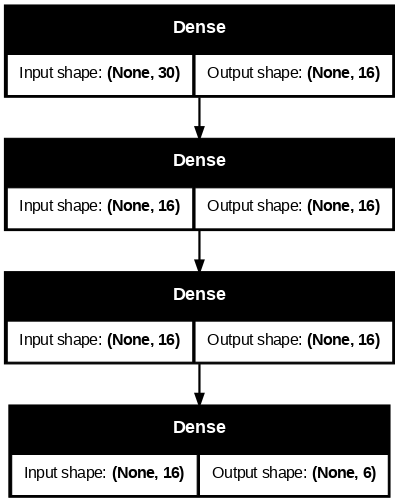

In [66]:
# Plot model architecture
keras.utils.plot_model(best_ann_model, dpi=80, show_shapes=True) # dpi: image resolution in dots per inch

In [67]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the output (Robotic spot-welding condition) for the test data
Predicted = best_ann_model.predict(TestData)

# Convert TestLabel and Predicted into vectors to calculate the confusion matrix and evaluation metrics
TestLabel_rev = np.argmax(TestLabel, axis=1)
Predicted_rev = np.argmax(Predicted, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(TestLabel_rev, Predicted_rev)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


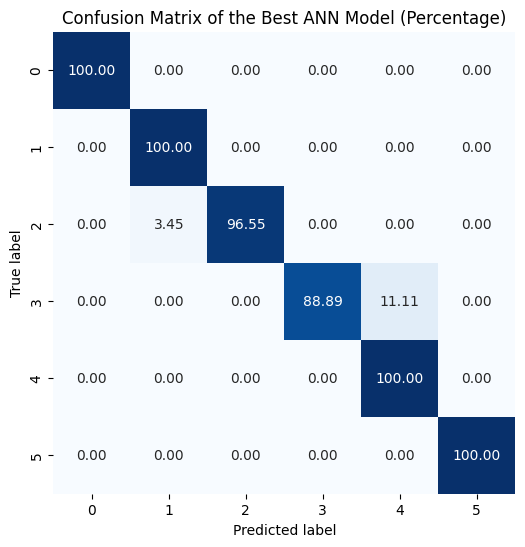

In [68]:
# Normalize confusion matrix to show percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap=plt.cm.Blues, cbar=False, square=True)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix of the Best ANN Model (Percentage)")
plt.show()